In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import scipy.optimize as sco
import re

抓股票代號

In [94]:
#抓美國市值前一百的股票代號
US100_stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://tw.tradingview.com/markets/stocks-usa/market-movers-large-cap/", headers=headers)

soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat"][target="_blank"]')

for tag in stock_tags:
    US100_stocks.append(tag.text)

利用前面抓的股票代號來抓歷史股價

In [95]:
#用yfinance抓美股股價
import yfinance as yf

random.seed(30) #固定種子複現結果
US10_Stocks = random.sample(US100_stocks, 10)

US10_stocks_prices = {}
for stock in US10_Stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(period="2y")
    US10_stocks_prices[stock] = historical_data

In [96]:
US10_Stocks

['AXP', 'ABT', 'ISRG', 'AMZN', 'ELV', 'BLK', 'ADBE', 'MCD', 'META', 'INTU']

利用股價生成日報酬

In [97]:
#將股價換算成日報酬率的函數
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [98]:
US10_stocks_returns = get_stocks_returns(US10_stocks_prices)

In [99]:
pd.DataFrame(US10_stocks_returns)

,AXP,ABT,ISRG,AMZN,ELV,BLK,ADBE,MCD,META,INTU
0,0.038262,-0.007788,0.015440,-0.000542,0.008396,0.003851,0.003040,0.007549,0.010666,0.008267
1,-0.007359,-0.014333,-0.038633,-0.028472,-0.015242,-0.019397,-0.032867,0.000617,-0.048920,-0.034230
2,0.012163,0.003030,0.020309,0.009788,0.009049,0.016013,0.014700,0.008804,0.020630,0.015228
3,-0.007782,0.005264,0.014754,0.012732,-0.009289,-0.001467,0.006370,0.007667,0.002042,0.002362
4,0.007631,0.012190,0.010151,0.012391,0.028588,0.005731,0.015167,0.004937,-0.013248,0.007117
...,...,...,...,...,...,...,...,...,...,...
497,0.000980,-0.006928,0.017523,0.016651,0.015522,-0.003863,-0.002535,-0.008963,0.005851,-0.000511
498,-0.013770,-0.012722,-0.008559,-0.040299,-0.012950,-0.016470,-0.010360,-0.007636,-0.006216,-0.010073
499,-0.008073,-0.007274,0.002373,0.000000,-0.007587,-0.005149,-0.007308,-0.015240,-0.004081,0.010036
500,0.002201,0.027112,0.016196,0.000000,0.005666,0.002875,0.004119,0.007396,0.020891,0.007870


計算統計數字

In [100]:
#計算平均報酬
US10_stocks_expected_return = {}
for stock in US10_stocks_returns:
    US10_stocks_expected_return[stock] = (US10_stocks_prices[stock]['Close'][len(US10_stocks_prices[stock])-1] - US10_stocks_prices[stock]['Close'][0]) / US10_stocks_prices[stock]['Close'][0]

mean_returns = pd.Series(US10_stocks_expected_return)
mean_returns

AXP    -0.086061
ABT    -0.151123
ISRG   -0.117970
AMZN   -0.226067
ELV     0.195127
BLK    -0.185994
ADBE   -0.114326
MCD     0.141866
META   -0.115442
INTU   -0.040680
dtype: float64

In [101]:
#共變異數矩陣
cov_matrix = pd.DataFrame(US10_stocks_returns).cov()
cov_matrix

,AXP,ABT,ISRG,AMZN,ELV,BLK,ADBE,MCD,META,INTU
AXP,0.000413,0.000133,0.000217,0.000252,0.000096,0.000245,0.000227,0.000088,0.000268,0.000278
ABT,0.000133,0.000220,0.000197,0.000164,0.000087,0.000157,0.000175,0.000072,0.000184,0.000197
ISRG,0.000217,0.000197,0.000545,0.000332,0.000108,0.000263,0.000341,0.000100,0.000385,0.000380
AMZN,0.000252,0.000164,0.000332,0.000706,0.000078,0.000296,0.000404,0.000086,0.000533,0.000462
ELV,0.000096,0.000087,0.000108,0.000078,0.000285,0.000086,0.000085,0.000071,0.000060,0.000105
BLK,0.000245,0.000157,0.000263,0.000296,0.000086,0.000359,0.000299,0.000093,0.000300,0.000319
ADBE,0.000227,0.000175,0.000341,0.000404,0.000085,0.000299,0.000646,0.000090,0.000473,0.000473
MCD,0.000088,0.000072,0.000100,0.000086,0.000071,0.000093,0.000090,0.000117,0.000089,0.000103
META,0.000268,0.000184,0.000385,0.000533,0.000060,0.000300,0.000473,0.000089,0.001161,0.000501
INTU,0.000278,0.000197,0.000380,0.000462,0.000105,0.000319,0.000473,0.000103,0.000501,0.000673


In [102]:
# 建立報酬率及標準差函數
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    return std, returns

# 建立隨機投資組合
# 自訂投資組合數
num_portfolios = 100000

def random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((10,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(US10_Stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return) / portfolio_std_dev
    return results, weights_record

In [103]:
# SAMPLE：隨機投資組合

results = np.zeros((10,num_portfolios))
weights_record = []
for i in range(num_portfolios):
    weights = np.random.random(len(US10_Stocks))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_std_dev
    results[1,i] = portfolio_return
    results[2,i] = (portfolio_return) / portfolio_std_dev

print('-' * 100)
print('平均報酬：\n',mean_returns )
print('-' * 100)
print('投組權重：', weights_record[0])
print('-' * 100)
print('報酬率：', results[1][0])
print('-' * 100)
print('標準差：', results[0][0])
print('-' * 100)

----------------------------------------------------------------------------------------------------
平均報酬：
 AXP    -0.086061
ABT    -0.151123
ISRG   -0.117970
AMZN   -0.226067
ELV     0.195127
BLK    -0.185994
ADBE   -0.114326
MCD     0.141866
META   -0.115442
INTU   -0.040680
dtype: float64
----------------------------------------------------------------------------------------------------
投組權重： [0.13792566 0.02096898 0.18045891 0.07402796 0.04921457 0.14179916
 0.1043237  0.04126783 0.10344811 0.14656512]
----------------------------------------------------------------------------------------------------
報酬率： -0.09381062345579724
----------------------------------------------------------------------------------------------------
標準差： 0.01776356792348121
----------------------------------------------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


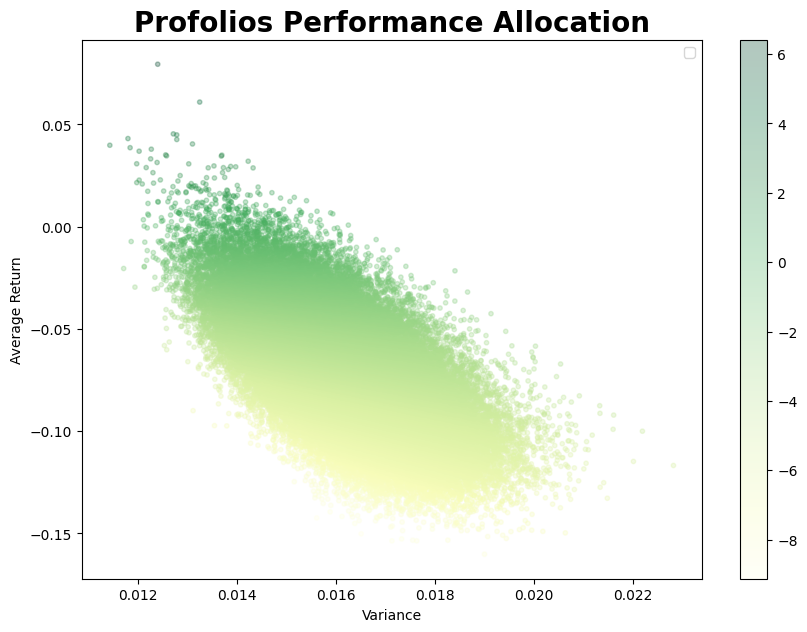

In [104]:
# 投資組合散佈圖

def profolios_allocation(mean_returns, cov_matrix, num_portfolios):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix)
      
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.title('Profolios Performance Allocation', fontsize=20,fontweight='bold',)
    plt.xlabel('Variance')
    plt.ylabel('Average Return')
    plt.legend(labelspacing=0.8)
    plt.show()
    
profolios_allocation(mean_returns, cov_matrix, num_portfolios)

In [105]:
# 建立風險函數
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

# 找出投資組合中最小風險
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0,1)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到相同投資組合報酬率下最小的風險
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到效率前緣樣本
def efficient_profolios(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

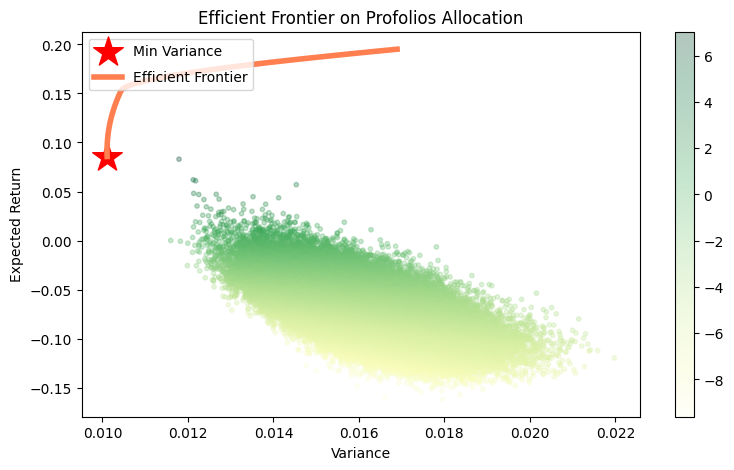

In [106]:
def display_efficient_frontier(mean_returns, cov_matrix, num_portfolios):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix)
     
    #點出所有投組報酬率及風險
    plt.figure(figsize=(9, 5))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    #找出最小風險投資組合及其報酬率
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_performance(min_vol['x'], mean_returns, cov_matrix)
    
    #點出最小風險之投資組合
    plt.scatter(sdp_min,rp_min,marker='*',color='red',s=500, label='Min Variance')

    #畫出所有投組樣本的效率前緣線    
    target = np.linspace(rp_min, mean_returns.max(), 50)
    efficient_portfolios = efficient_profolios(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], 
             target, linestyle='-', color='coral',linewidth=4, label='Efficient Frontier') 
    plt.title('Efficient Frontier on Profolios Allocation')
    plt.xlabel('Variance')
    plt.ylabel('Expected Return')
    plt.legend(labelspacing=0.9 ,loc ='upper left')
    plt.show()
    
display_efficient_frontier(mean_returns, cov_matrix, num_portfolios)

切線法

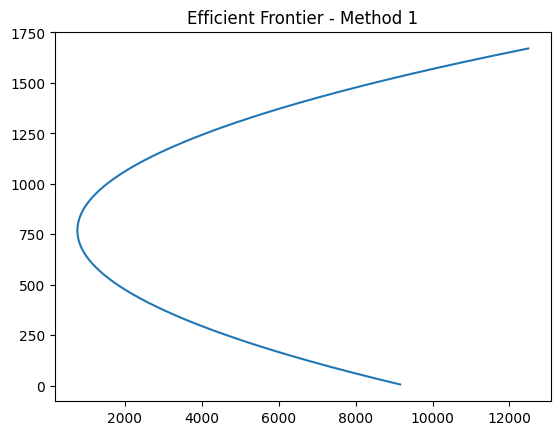

In [118]:
f = mean_returns.values

#建立不同的無風險利率(-1 ~ 1)
Rfs = np.linspace(-1, 1, 1000)

weights = []
for Rf in Rfs:
    Rf = np.full((f.shape[0], 1), Rf)
    f = f.reshape(10, 1)
    Rbar = f + Rf
    V = cov_matrix.values
    V_inv = np.linalg.inv(V)
    V_inv_Rbar = np.dot(V_inv, Rbar)

    # 計算 V^(-1) * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
    ones_vector = np.ones((10, 1))
    V_inv_ones = np.dot(V_inv, ones_vector)

    # 計算 Rf * (V^(-1) * 1)
    Rf_V_inv_ones = Rf * V_inv_ones
    Z = V_inv_Rbar - Rf_V_inv_ones

    # 計算 Z.T * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
    Z_transpose = Z.T
    Z_dot_ones = np.dot(Z_transpose, ones_vector)

    # 最後計算 X
    X = V_inv_Rbar - Rf_V_inv_ones / Z_dot_ones
    weights.append(X)


vars = []
fp = []
for weight in weights:
    var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
    vars.append(float(var))
    fp.append(float(np.dot(weight.T, f)))

plt.title('Efficient Frontier - Method 1')
plt.plot(vars, fp)


切火腿法

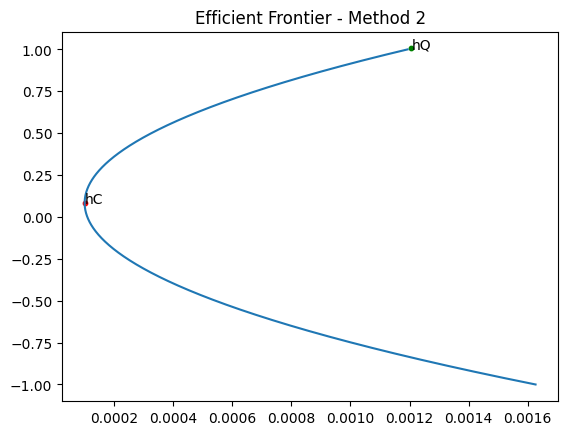

In [119]:
f = mean_returns.values
f = f.reshape(10, 1)
#建立不同的無風險利率(-1 ~ 1)
Rfs = np.linspace(-1, 1, 1000)

weights = []
e = np.ones((10, 1))

for u in Rfs:
    V = cov_matrix.values
    V_inv = np.linalg.inv(V)
    A = e.T @ V_inv @ e
    B = e.T @ V_inv @ f
    C = f.T @ V_inv @ f
    D = (A @ C) - (B ** 2)
    _lambda = (C - u * B) / D
    _gamma = (A * u - B) / D
    h = _lambda * V_inv @ e + _gamma * V_inv @ f
    weights.append(h)

hC = (np.linalg.inv(cov_matrix.values) @ e) / (e.T @ np.linalg.inv(cov_matrix.values) @ e)
hQ = (np.linalg.inv(cov_matrix.values) @ f) / (f.T @ np.linalg.inv(cov_matrix.values) @ e)

hC_point = (np.dot(hC.T, cov_matrix.values) @ hC, np.dot(hC.T, f))
hQ_point = (np.dot(hQ.T, cov_matrix.values) @ hQ, np.dot(hQ.T, f))

vars = []
fp = []
for weight in weights:
    var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
    vars.append(float(var))
    fp.append(float(np.dot(weight.T, f)))

fig, ax = plt.subplots()
plt.title('Efficient Frontier - Method 2')
plt.scatter(*hC_point, c='red', s=10)
plt.annotate('hC', xy=hC_point)
plt.scatter(*hQ_point, c='green', s=10, label='QML')
plt.annotate('hQ', xy=hQ_point)
plt.plot(vars, fp)